# **Gravitational Wave Classifier Using Convolutional Neural Networks**

***Universidad de Guadalajara.***

**Aldo A. Álvarez.** *(aldoa.alvarez@alumnos.udg.mx)*



<div>
<img src="https://news.uchicago.edu/sites/default/files/styles/full_width/public/images/image/20171013/ligo-illustration.jpg?itok=UMHAepJo" width="20000"/>
</div>

In this notebook we will build a Convolutional Neural Network (CNN). The network will be trained with data from Gravitaional Wave (GW) detections from LIGO to make a classifier that can tell wether there is a GW or not in a given image. 

## **Setup**

The first step before we start working with the data is to import some Python libraries that will be needed to process the data:

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from sklearn import model_selection
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import sklearn.metrics as metrics

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## **Import Data**

Now we need to import the dataset with which we will train the CNN later on. This data consists of timeseries of real Noise from LIGO detectors, into which GW templates from Core-Collapse Super Novae Explosion events have been injected. The GW injections are theoretical simulations of Super Novae events, and they were created by Scheideger as described in his [research paper](https://arxiv.org/pdf/1001.1570v2.pdf).

The data that we use here has already been preprocessed. The data from LIGO detectors contains a lot of noise, so usually it is necessary to apply some filters to clean it. Some of those filters include: 


*   Bandpass filtering,
*   Whitening,
*   Q-transform.

After applying these filters, the timeseries were cut into samll windows, each corresponding to 0.5 seconds of data. For each GW template injected in the timeseries we took three windows showing only noise from the detectors, and three windows showing a section of the GW template + noise.

<div>
<img src="https://drive.google.com/uc?id=1bT0ArkEas13LT_7WL8ccYmwILAxp0G3X" width="600"/>
</div>

The datasets correspond to a particular distance at which the detection was taken. For each distance, we have 4 subsets of data (Jobs), all with the same general characteristics but including different GW templates.

The datasets come in a json file. We download and call them using pandas:

In [9]:
import random
from google_drive_downloader import GoogleDriveDownloader

class Constants:
    
    
    SEED = 0
    
    # Paths to the data files
    dfJob2 = '/dfJob2.json' 
    dfJob3 = '/dfJob3.json'
    dfJob4 = '/dfJob4.json'
    dfJob5 = '/dfJob5.json'

constants = Constants
random.seed(constants.SEED)
np.random.seed(constants.SEED)

!wget -O /dfJob2.json https://www.dropbox.com/s/i7c1oxr9fo0py8a/DataJob2_Factor31.62.json?dl=0
!wget -O /dfJob3.json https://www.dropbox.com/s/9fgfigfz9np6k6y/DataJob3_Factor31.62.json?dl=0
!wget -O /dfJob4.json https://www.dropbox.com/s/8a1wpwfadfhecbt/DataJob4_Factor31.62.json?dl=0
!wget -O /dfJob5.json https://www.dropbox.com/s/h1aiw2ytan9yl9n/DataJob5_Factor31.62.json?dl=0

--2022-05-09 19:52:22--  https://www.dropbox.com/s/i7c1oxr9fo0py8a/DataJob2_Factor31.62.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/i7c1oxr9fo0py8a/DataJob2_Factor31.62.json [following]
--2022-05-09 19:52:22--  https://www.dropbox.com/s/raw/i7c1oxr9fo0py8a/DataJob2_Factor31.62.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc53bfcc87439d75d53b73fc1c85.dl.dropboxusercontent.com/cd/0/inline/Bk9nPm1Men85jPU6Gh8WFEBj3B2wT_BOEWXR-g-zbEtCTwguoD-UVGtuebYrGuxFEoujyRlpw0Y4HJPryNayfs-Ye_Qmqz_Pr1FXpnqTQANNQhUT9CEdM6jsLFmbhEJnRduD0zAsfEOAk3EDarmK3qR6Q0CPimKMWnflIDqX148eyg/file# [following]
--2022-05-09 19:52:22--  https://uc53bfcc87439d75d53b73fc1c85.dl.dropboxusercontent.com/cd/0/inline/Bk9nPm1Men85jPU6Gh8WFEBj

In [10]:
dfJob2 = pd.read_json(constants.dfJob2)
dfJob3 = pd.read_json(constants.dfJob3)
dfJob4 = pd.read_json(constants.dfJob4)
dfJob5 = pd.read_json(constants.dfJob5)

These datasets include: 
* the pixels corresponding to the detection from H1 and L1,
* the time at which the window was extracted from the time series,
* an injection indicator with 0 if it's just Noise or 1 if it's GW+Noise,
* the GW template that the window includes (if any).

In this case, the data corresponds to GW injections at a distance of **0.316 Kpc**.

In [70]:
factor = 31.62

## **Change Pixel lists to np arrays**

The data corresponding to the detection images inside the json file comes in a 1D pixel array. So before we can manipulate the pixels to rebuild the images, we need to convert them to numpy arrays.  

In [11]:
dfJob2['Pixels H1'] = dfJob2['Pixels H1'].apply(lambda x: np.array(x))
dfJob2['Pixels L1'] = dfJob2['Pixels L1'].apply(lambda x: np.array(x))

dfJob3['Pixels H1'] = dfJob3['Pixels H1'].apply(lambda x: np.array(x))
dfJob3['Pixels L1'] = dfJob3['Pixels L1'].apply(lambda x: np.array(x))

dfJob4['Pixels H1'] = dfJob4['Pixels H1'].apply(lambda x: np.array(x))
dfJob4['Pixels L1'] = dfJob4['Pixels L1'].apply(lambda x: np.array(x))

dfJob5['Pixels H1'] = dfJob5['Pixels H1'].apply(lambda x: np.array(x))
dfJob5['Pixels L1'] = dfJob5['Pixels L1'].apply(lambda x: np.array(x))

We can confirm that they were successfully converted:

In [12]:
type(dfJob2['Pixels L1'].iloc[0])

numpy.ndarray

And now we can finally visualize the dataset with which we will be working:

In [13]:
dfJob2.head()

,Pixels H1,Pixels L1,Twin,GW injection,Template,Theta,Phi,Distance
0,"[[0.6671221011, 0.8246112875, 1.0935741992, 1....","[[0.6268522979000001, 0.2885270893, 0.12907088...",869.170290,1,sch3,NaN,NaN,0.031626
1,"[[0.1273723069, 0.027398567300000003, 0.000364...","[[1.5275692769, 1.6736162632, 1.5662285443, 1....",10.491783,0,NaN,NaN,NaN,0.031626
2,"[[0.9715096099, 1.0902210682, 1.25730067109999...","[[2.8905482979, 2.5858256658, 2.0183065708, 1....",10.491783,1,sch2,NaN,NaN,0.031626
3,"[[1.1038850136, 1.3463503, 1.7232404994000001,...","[[0.7286555221000001, 0.49838899600000003, 0.3...",890.915274,0,NaN,NaN,NaN,0.031626
4,"[[2.129061328, 2.4446815326999998, 2.632915256...","[[7.090021403, 4.6660909789, 2.6294095984, 1.2...",1149.403197,0,NaN,NaN,NaN,0.031626


## **Train-Test Split**

We will use 75\% of the data for training and 25\% for testing. This means that, from the for Jobs of data that we have, we need to choose three for training and one for testing. All Jobs contain similar data, so they can be chose arbitrarily.

In [14]:
###
c = pd.concat([dfJob2,dfJob3,dfJob4])
df_train = c.sample(frac=1).reset_index(drop=True)
###

In [15]:
###
df_test = dfJob5
df_name = 'Job5'
###

The dataset has some pictures with dimensions 47X48. All images must be 48X48, so we need to filter that data. This is just a small error that occurs during the process of separating the initial timeseries into small time windows.

### Drop defective data

In [16]:
len(df_train)

1098

In [17]:
len(df_test)

366

In [18]:
k = []
for i in range(len(df_train)):
  if df_train['Pixels H1'].iloc[i].shape != (48,48) :
    k.append(i)

In [19]:
q = []
for i in range(len(df_test)):
  if df_test['Pixels H1'].iloc[i].shape != (48,48) :
    q.append(i)

The ammount of images that need to be deleted from the training set is:

In [20]:
len(k) 

30

The ammount of images that need to be deleted from the testing set is:

In [21]:
len(q)

17

Now we drop those images from the datasets, otherwise they will cause a dimension error in the CNN:

In [22]:
df_train = df_train.drop(k)
df_test = df_test.drop(q)

We will see a reduction in our datasets:

In [23]:
len(df_train)

1068

In [24]:
len(df_test)

349

## **Reshape arrays**

Now we need to reshape the 1D pixel arrays into 48X48 pixel images. We will do this for H1 and L1 separately, generating images with dimension (48,48,1). Also, we will do the same but with H1 and L1 together, and we will have images with shape (48,48,2).

### Train H1

In [25]:
trainH1 = df_train['Pixels H1'] 

In [26]:
trainH1_arr = np.empty((0,48,48), dtype=float)

In [27]:
for i in range(len(trainH1)):
  a = trainH1.iloc[i]
  trainH1_arr = np.append(trainH1_arr, a.reshape(1,48,48), axis=0)

In [28]:
trainH1_arr.shape

(1068, 48, 48)

### Test H1

In [29]:
testH1 = df_test['Pixels H1'] 

In [30]:
testH1_arr = np.empty((0,48,48), dtype=float)

In [31]:
for i in range(len(testH1)):
  a = testH1.iloc[i]
  testH1_arr = np.append(testH1_arr, a.reshape(1,48,48), axis=0)

In [32]:
testH1_arr.shape

(349, 48, 48)

### Train L1

In [33]:
trainL1 = df_train['Pixels L1'] 

In [34]:
trainL1_arr = np.empty((0,48,48), dtype=float)

In [35]:
for i in range(len(trainL1)):
  a = trainL1.iloc[i]
  trainL1_arr = np.append(trainL1_arr, a.reshape(1,48,48), axis=0)

In [36]:
trainL1_arr.shape

(1068, 48, 48)

### Test L1

In [37]:
testL1 = df_test['Pixels L1'] 

In [38]:
testL1_arr = np.empty((0,48,48), dtype=float)

In [39]:
for i in range(len(testL1)):
  a = testL1.iloc[i]
  testL1_arr = np.append(testL1_arr, a.reshape(1,48,48), axis=0)

In [40]:
testL1_arr.shape

(349, 48, 48)

### Train All

In [41]:
trainAll_arr = np.empty((0,48,48,2), dtype=float)

In [42]:
for i in range(len(trainL1_arr)):
  x = np.append(trainH1_arr[i].reshape(48,48,1), trainL1_arr[i].reshape(48,48,1), axis=2)
  trainAll_arr = np.append(trainAll_arr, x.reshape(1,48,48,2), axis=0)

In [43]:
trainAll_arr.shape

(1068, 48, 48, 2)

### Test All

In [44]:
testAll_arr = np.empty((0,48,48,2), dtype=float)

In [45]:
for i in range(len(testL1_arr)):
  x = np.append(testH1_arr[i].reshape(48,48,1), testL1_arr[i].reshape(48,48,1), axis=2)
  testAll_arr = np.append(testAll_arr, x.reshape(1,48,48,2), axis=0)

In [46]:
testAll_arr.shape

(349, 48, 48, 2)

###  Train Labels (y data)

In [47]:
trainy = df_train['GW injection']

In [48]:
len(trainy)

1068

In [49]:
trainy[10]

1

In [50]:
train_labels = []

In [51]:
for i in range(len(trainy)):
  train_labels.append(trainy.iloc[i])
train_labels = np.array(train_labels)

In [52]:
train_labels.shape

(1068,)

###  Test Labels (y data)

In [53]:
testy = df_test['GW injection']

In [54]:
testy.iloc[300]

0

In [55]:
test_labels = []

In [56]:
for i in range(len(testy)):
  test_labels.append(testy.iloc[i])
test_labels = np.array(test_labels)

In [57]:
test_labels.shape

(349,)

## **CNN**

<div>
<img src="https://drive.google.com/uc?id=1B8NoPWXWv5WwhLc59MYQ0z-MIBpF4eB3" width="800"/>
</div>

In [58]:

class_names = ['Noise','GW']

### 3-Stack CNN

#### H1

In [59]:
modelLeNetH1 = keras.Sequential()
modelLeNetH1.add(keras.layers.Conv2D(16, (3,3), padding = "same", 
                                   activation='relu', input_shape=(48, 48, 1)))
modelLeNetH1.add(keras.layers.MaxPooling2D((2,2)))
modelLeNetH1.add(keras.layers.Conv2D(32 , (3,3) , activation='relu')) 
modelLeNetH1.add(keras.layers.MaxPooling2D((2,2)))
modelLeNetH1.add(keras.layers.Conv2D(64, (3,3) , activation='relu')) 

modelLeNetH1.add(keras.layers.Flatten())
modelLeNetH1.add(keras.layers.Dense(64, activation='relu')) 
modelLeNetH1.add(keras.layers.Dense(2))

In [60]:
modelLeNetH1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 5184)              0

In [61]:
train_images = trainH1_arr.reshape(-1, 48, 48, 1)

modelLeNetH1.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = modelLeNetH1.fit(train_images, train_labels, batch_size = 28, epochs = 15)

Epoch 1/15
39/39 [==============================] - 12s 10ms/step - loss: 0.4990 - accuracy: 0.8801
Epoch 2/15
39/39 [==============================] - 0s 7ms/step - loss: 0.2450 - accuracy: 0.9260
Epoch 3/15
39/39 [==============================] - 0s 7ms/step - loss: 0.1881 - accuracy: 0.9316
Epoch 4/15
39/39 [==============================] - 0s 7ms/step - loss: 0.1491 - accuracy: 0.9485
Epoch 5/15
39/39 [==============================] - 0s 7ms/step - loss: 0.1044 - accuracy: 0.9691
Epoch 6/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0814 - accuracy: 0.9766
Epoch 7/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0679 - accuracy: 0.9775
Epoch 8/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0531 - accuracy: 0.9813
Epoch 9/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0343 - accuracy: 0.9916
Epoch 10/15
39/39 [==============================] - 0s 7ms/step - loss: 0.0259 - accuracy: 0.9944
Epoch 11/15
39/39

In [62]:
test_imagesH1 = testH1_arr.reshape(-1,48,48,1)
test_loss, test_acc = modelLeNetH1.evaluate( test_imagesH1, test_labels )
print('Accuracy ', test_acc)

11/11 [==============================] - 0s 9ms/step - loss: 0.2951 - accuracy: 0.9427
Accuracy  0.9426934123039246


In [63]:
predictions = modelLeNetH1.predict(test_imagesH1)
predictions.shape

(349, 2)

In [64]:
predicted_label = np.zeros(len(predictions))

for i in range(len(predictions)):
    predicted_label[i] = int(np.argmax(predictions[i]))

##### Confusion Matrix

Now we use the testing data results to create a confusion matrix

In [65]:
predicted_label = predicted_label.astype(int)

cnf_matrix = tf.math.confusion_matrix(
    test_labels, predicted_label, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)
print(cnf_matrix)

tf.Tensor(
[[169   4]
 [ 16 160]], shape=(2, 2), dtype=int32)


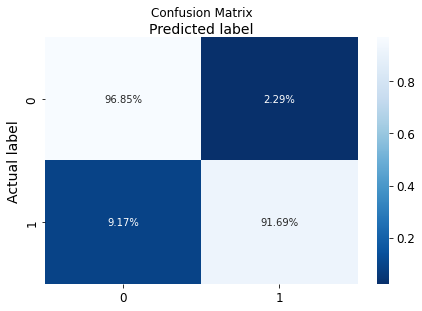

In [72]:
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix*2/np.sum(cnf_matrix), annot = True, cmap = 'Blues_r', fmt='.2%')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion Matrix', y = 1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [67]:
for i in range(len(class_names)):
    print((i,class_names[i]))

(0, 'Noise')
(1, 'GW')


### ROC curve

In [68]:
probsH1 = modelLeNetH1.predict(test_imagesH1)

# calculate the fpr and tpr for all thresholds of the classification
  #H1
predsH1 = probsH1[:,1]
fprH1, tprH1, thresholdH1 = metrics.roc_curve(testy, predsH1)
roc_aucH1 = metrics.auc(fprH1, tprH1)

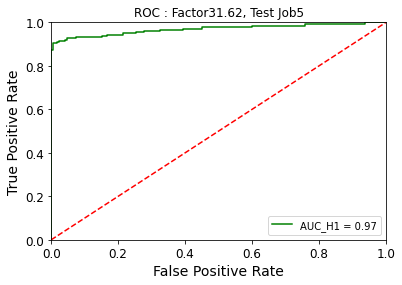

In [71]:
# method I: plt
plt.title(f'ROC : Factor{factor:.2f}, Test {df_name}')
plt.plot(fprH1, tprH1, 'g', label = 'AUC_H1 = %0.2f' % roc_aucH1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### L1-Activity

Now you can generate and train a CNN model, but this time using the data from detector L1. The code should be exactly the same as in the previous section, just make sure that you're calling the correct input data for each function.

In [ ]:
# Define the CNN model: "modelLeNetL1"


In [ ]:
# Visualize the structure of the model
#modelLeNetL1.summary()

In [ ]:
#Define train_images with trainL1_arr data:

# Train the model:


In [ ]:
# Define test_imagesL1 with testL1_arr data:


In [ ]:
# Make predictions
predictions = modelLeNetL1.predict(test_imagesL1)
predictions.shape

In [ ]:
predicted_label = np.zeros(len(predictions))

for i in range(len(predictions)):
    predicted_label[i] = int(np.argmax(predictions[i]))

##### Matriz de Confusión

To build the confusion matrix for L1 we can use the exact same code without having to make any changes.

In [ ]:
predicted_label = predicted_label.astype(int)

cnf_matrix = tf.math.confusion_matrix(
    test_labels, predicted_label, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)
print(cnf_matrix)

In [ ]:
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix*2/np.sum(cnf_matrix), annot = True, cmap = 'Blues_r', fmt='.2%')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Matriz de confusión', y = 1.1)
plt.ylabel('Etiqueta actual')
plt.xlabel('Etiqueta de predicción')
plt.show()

In [ ]:
for i in range(len(class_names)):
    print((i,class_names[i]))

#### H1+L1

Finally, we can also create another CNN model that takes both the data from H1 and L1 at the same time. In this case, the input data will have dimensions (48,48,2) because now we have two images of 48X48 pixels stacked one on top of the other.

In [ ]:
modelLeNetAll = keras.Sequential()
modelLeNetAll.add(keras.layers.Conv2D(16, (3,3), padding = "same",
                                   activation='relu', input_shape=(48, 48, 2))) # input shape changes to (48,48,2)
modelLeNetAll.add(keras.layers.MaxPooling2D((2,2)))
modelLeNetAll.add(keras.layers.Conv2D(32 , (3,3) , activation='relu'))
modelLeNetAll.add(keras.layers.MaxPooling2D((2,2)))
modelLeNetAll.add(keras.layers.Conv2D(64, (3,3) , activation='relu')) 

modelLeNetAll.add(keras.layers.Flatten())
modelLeNetAll.add(keras.layers.Dense(64, activation='relu')) 
modelLeNetAll.add(keras.layers.Dense(2))

In [ ]:
modelLeNetAll.summary()

In [ ]:
train_images = trainAll_arr.reshape(-1, 48, 48, 2) # shape changes to (48,48,2)

modelLeNetAll.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

history = modelLeNetAll.fit(train_images, train_labels, batch_size = 28, epochs = 15)

In [ ]:
test_imagesAll = testAll_arr.reshape(-1,48,48,2) # Shape changes to (48,48,2)
test_loss, test_acc = modelLeNetAll.evaluate( test_imagesAll, test_labels )
print('Accuracy ', test_acc)

In [ ]:
predictions = modelLeNetAll.predict(test_imagesAll)
predictions.shape

In [ ]:
predicted_label = np.zeros(len(predictions))

for i in range(len(predictions)):
    predicted_label[i] = int(np.argmax(predictions[i]))

##### Confusion Matrix

In [ ]:
predicted_label = predicted_label.astype(int)

cnf_matrix = tf.math.confusion_matrix(
    test_labels, predicted_label, num_classes=None, weights=None, dtype=tf.dtypes.int32,
    name=None
)
print(cnf_matrix)

In [ ]:
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(cnf_matrix*2/np.sum(cnf_matrix), annot = True, cmap = 'Blues_r', fmt='.2%')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Matriz de confusión', y = 1.1)
plt.ylabel('Etiqueta actual')
plt.xlabel('Etiqueta de predicción')
plt.show()

In [ ]:
for i in range(len(class_names)):
    print((i,class_names[i]))